In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from custom_classes import NasaDataset, SimpleAE, split_dataset, seed_everything, split_anomaly_normal
from ae_metrics import MAPE
from rul_metrics import RMSELoss
from normalisation import standard_scaling, min_max_scaling

import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [3]:
seed = 37

train_dataset = NasaDataset('../datasets/clean_train_data.csv')
train_dataset, anomaly_dataset = split_anomaly_normal(train_dataset)
seed_everything(seed)
train_dataset, test_dataset = split_dataset(train_dataset, test_size=0.1)
seed_everything(seed)
train_dataset, val_dataset = split_dataset(train_dataset, test_size=0.3)
# test_dataset = NasaDataset('../datasets/test.csv')

norm_func = min_max_scaling
try:
    norm_name = repr(norm_func).split(' ', maxsplit=2)[1]
except IndexError:
    norm_name = 'no_scaling'
for dtset in (train_dataset, val_dataset, test_dataset, anomaly_dataset):
    dtset.to(device)
    if norm_func:
        norm_func(dtset)

seed_everything(seed)
g = torch.Generator()
g.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
test_loader = DataLoader(val_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
val_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
# test_loader = DataLoader(test_dataset, batch_size=..., shuffle=...)
print(f'Train: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}')
print(f'Anomaly: {len(anomaly_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (8, 4, 2)

seed_everything(seed)
model_ae = SimpleAE(input_shape, layers_sizes).to(device)
loss_func = nn.MSELoss()
metric_func = MAPE()
optimiser = optim.AdamW(model_ae.parameters(),
                       lr=1e-3)
optimiser_name = repr(optimiser).split(' ', maxsplit=1)[0]

Train: 5473
Validation: 1840
Test: 818
Anomaly: 12500


In [4]:
def plot_history(history_df: pd.DataFrame, ylabel: str = None, save_path: str = None):
    history_df = history_df.melt(ignore_index=False).iloc[1:]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    sns.lineplot(data=history_df,
                x=history_df.index,
                y='value',
                hue='variable')

    ax.set_ylabel(ylabel)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [5]:
def check_path(pth):
    if not os.path.exists(pth):
        os.makedirs(pth)
    return pth

In [6]:
epochs = 100
history = list()

for epoch in range(epochs):
    train_losses = list()
    train_metrics = list()
    for dta in train_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)

        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
        train_metrics.append(metric.item())
    
    with torch.no_grad():
        val_losses = list()
        val_metrics = list()
        for dta in val_loader:
            sample = dta['sensors']
            sample = sample.to(device)
            _, reconstruction = model_ae(sample)

            loss = loss_func(reconstruction, sample)
            metric = metric_func(reconstruction, sample)

            val_losses.append(loss.item())
            val_metrics.append(metric.item())
    
    train_loss, val_loss = mean(train_losses), mean(val_losses)
    train_metrics, val_metrics = mean(train_metrics), mean(val_metrics)
    history.append((epoch, train_loss, val_loss, train_metrics, val_metrics))
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'{epoch+1:>3}/{epochs:>3}: {train_loss=:.4f}, {val_loss=:.4f}, {train_metrics=:.4f}%, {val_metrics=:.4f}%')

with torch.no_grad():
    test_losses = list()
    test_metrics = list()
    for dta in test_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)
        test_losses.append(loss.item())
        test_metrics.append(metric.item())
    test_loss = mean(test_losses)
    test_metrics = mean(test_metrics)
    print(f'\n{test_loss=:.4f}, {test_metrics=:.4f}%')


with torch.no_grad():
    anomaly_losses = list()
    anomaly_metrics = list()
    for dta in anomaly_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        loss = loss_func(reconstruction, sample)
        metric = metric_func(reconstruction, sample)
        anomaly_losses.append(loss.item())
        anomaly_metrics.append(metric.item())
    anomaly_loss = mean(anomaly_losses)
    anomaly_metric = mean(anomaly_metrics)
    print(f'\n{anomaly_loss=:.4f}, {anomaly_metric=:.4f}%')

# -------------------------------------------------- #
name = str(layers_sizes)
models_path = '../Models/'
plot_path = '../Plots/history/'


if False:
    pth = check_path(os.path.join(models_path, optimiser_name, norm_name))
    torch.save(model_ae.state_dict(), os.path.join(pth, f'{name}.pth'))

if False:
    columns = ('epoch', 'train_loss', 'val_loss', 'train_metric', 'val_metric')
    total_history_df = pd.DataFrame(history, columns=columns).set_index('epoch')

    history_df = total_history_df.loc[:,('train_loss', 'val_loss')]
    pth = check_path(os.path.join(plot_path, optimiser_name, 'loss', norm_name))
    plot_history(history_df, ylabel='MSE', save_path=os.path.join(pth, f'{name}.png'))

    pth = check_path(os.path.join(plot_path, optimiser_name, 'metric', norm_name))
    history_df = total_history_df.loc[:,('train_metric', 'val_metric')]
    plot_history(history_df, ylabel='MAPE', save_path=os.path.join(pth, f'{name}.png'))

 10/100: train_loss=0.0218, val_loss=0.0208, train_metrics=inf%, val_metrics=inf%
 20/100: train_loss=0.0131, val_loss=0.0131, train_metrics=inf%, val_metrics=inf%
 30/100: train_loss=0.0124, val_loss=0.0123, train_metrics=inf%, val_metrics=inf%
 40/100: train_loss=0.0120, val_loss=0.0120, train_metrics=inf%, val_metrics=inf%
 50/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 60/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 70/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 80/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
 90/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%
100/100: train_loss=0.0118, val_loss=0.0118, train_metrics=inf%, val_metrics=inf%

test_loss=0.0154, test_metrics=inf%

anomaly_loss=0.0201, anomaly_metric=inf%


In [26]:
columns = ('epoch', 'train_loss', 'val_loss', 'train_metric', 'val_metric')
total_history_df = pd.DataFrame(history, columns=columns).set_index('epoch')

history_df = total_history_df.loc[:,('train_loss', 'val_loss')].iloc[1:].melt(ignore_index=False)

anomaly_losses_transfromed = np.array(anomaly_losses)[:600].reshape(-1, 6).mean(axis=1)[:-1]

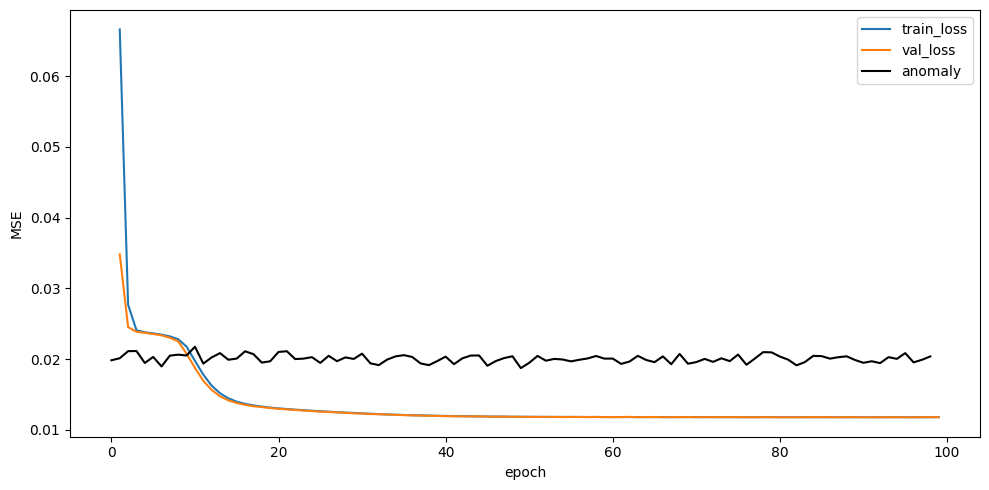

In [28]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

sns.lineplot(data=history_df,
             x=history_df.index,
             y='value',
             hue='variable',
             ax=ax)

ax.plot(anomaly_losses_transfromed, color='k', label='anomaly')
ax.legend()

ax.set_ylabel('MSE')

plt.tight_layout()
plt.savefig('../Plots/history/AdamW/norm-anom.png')
plt.show()